In [1]:
import nexradaws
from datetime import datetime as datetime
from datetime import timedelta
import pyart
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from cylindrical_conversion import interp_to_equal_grid
from cylindrical_conversion import x_y_grid_to_cylindrical
import pandas as pd
import cartopy.crs as ccrs
import os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
conn = nexradaws.NexradAwsInterface()

In [4]:
time = datetime(2021, 8, 21, 0, 0) # YYYY, MM,DD,HH,MM
startTime = time + timedelta(hours=12)
endTime = time + timedelta(hours=48)
storageL2 = '/Users/acheung/data/ground_radar/'
radar_desired = 'KOKX'
radar_Scans = conn.get_avail_scans_in_range(startTime, endTime, radar_desired)
conn.download(radar_Scans, storageL2) # Downloads the radar files to the location

Downloaded KOKX20210821_121100_V06
Downloaded KOKX20210821_122158_V06
Downloaded KOKX20210821_120539_V06
Downloaded KOKX20210821_122720_V06
Downloaded KOKX20210821_121621_V06
Downloaded KOKX20210821_120017_V06
Downloaded KOKX20210821_123242_V06
Downloaded KOKX20210821_124850_V06
Downloaded KOKX20210821_123819_V06
Downloaded KOKX20210821_124334_V06
Downloaded KOKX20210821_125910_V06
Downloaded KOKX20210821_125400_V06
Downloaded KOKX20210821_125910_V06_MDM
Downloaded KOKX20210821_130420_V06
Downloaded KOKX20210821_131440_V06
Downloaded KOKX20210821_131949_V06
Downloaded KOKX20210821_130930_V06
Downloaded KOKX20210821_132459_V06
Downloaded KOKX20210821_133009_V06
Downloaded KOKX20210821_133519_V06
Downloaded KOKX20210821_134028_V06
Downloaded KOKX20210821_134556_V06
Downloaded KOKX20210821_135139_V06
Downloaded KOKX20210821_135649_V06
Downloaded KOKX20210821_135649_V06_MDM
Downloaded KOKX20210821_140159_V06
Downloaded KOKX20210821_140710_V06
Downloaded KOKX20210821_141220_V06
Downloaded K

In [5]:
def process_file(i,point):
    """ Processes a radar file 
    
    Parameters
    ----------
    i: the file number to open
    """
    
    file = radarScans[i].filename
    x = 0
    from distance import distance_calculator
    # Read the file
    radar = pyart.io.read_nexrad_archive(storageL2+'/'+file)       
    sweep_0 = radar.get_slice(0)
    lat = radar.gate_latitude['data'][sweep_0]
    lon = radar.gate_longitude['data'][sweep_0]
    ref = radar.fields['reflectivity']['data'][sweep_0]

    radar_long = radar.longitude['data']
    radar_lat = radar.latitude['data']
    
    # Find reflectivity values within a radius
    dist = distance_calculator(lon, lat, point) # Returns distance array from point
    ind = np.where(dist < 15) # Returns all indices within a distance in km
    latind = ind[0]
    lonind = ind[1]
    refvalue = ref[latind,lonind] # Call reflectivity values within this radius
    
    # Finds the index of the crash site
    ind = np.where(dist == np.min(dist)) # Finds the closest index
    radarlatind = ind[0][0]
    radarlonind = ind[1][0]

    # Calculate Distance from Radar
    distfromradar = distance_calculator(lon,lat,(radar_long,radar_lat))
    radardist = distfromradar[radarlatind,radarlonind]

    namer = file

    # Create Date Time Object
    date_time_str = namer[4:12]+namer[13:19]
    date_time_obj = datetime.strptime(date_time_str, '%Y%m%d%H%M%S')

    return dict(scan=file, refvalue=refvalue, radardist=radardist, date_time_obj=date_time_obj)

In [6]:
# radar = pyart.io.read_nexrad_archive(storageL2+'/'+radar_Scans[-5].filename)       
# sweep_0 = radar.get_slice(0)
# lat = radar.gate_latitude['data'][sweep_0]
# lon = radar.gate_longitude['data'][sweep_0]
# ref = radar.fields['reflectivity']['data'][sweep_0]

# radar_long = radar.longitude['data']
# radar_lat = radar.latitude['data']
# # plt.pcolormesh(x_sort,y_sort,ref[np.argsort(x_grid),np.argsort(y_grid)])
# # plt.colorbar()
# # # plt.scatter(radar_long,radar_lat)
# # plt.scatter(18000,-195000)

In [7]:
desired_iterations = np.arange(0,len(radar_Scans),2)

for k in desired_iterations:
    if len(str(radar_Scans[k])) > 67:
        k = k+1
    radar = pyart.io.read_nexrad_archive(storageL2+'/'+radar_Scans[k].filename)       
    test_grid_radar = pyart.map.grid_from_radars(radar,(10,100,100),((0,10000),(-300000,300000),(-300000,300000)))
    radar_xr = test_grid_radar.to_xarray()

    # Make the figure larger
    fig = plt.figure()

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())

    # Make a filled contour plot
    radar_plot = ax.pcolormesh(radar_xr['lon'],radar_xr['lat'],radar_xr['reflectivity'].isel(z=2)[0],
                transform = ccrs.PlateCarree(),vmin=-10,vmax=50,cmap='jet')

    # Add coastlines
    ax.coastlines()
    plt.colorbar(radar_plot,label='Reflectivity (dBZ)')
    ax.set_title('Hurricane Henri ('+str(radar_xr['time'].values[0])[0:-7]
                 +') \n z = ' + str(int(radar_xr['z'][2].round(0))) + ' m')
    plt.tight_layout()
    storm_and_year = 'Henri_2021_KOKX'
    if os.path.exists('/Users/acheung/data/ground_radar/storms/'+storm_and_year) == False:
        os.mkdir('/Users/acheung/data/ground_radar/storms/'+storm_and_year)
    
    plt.savefig('/Users/acheung/data/ground_radar/storms/'+storm_and_year+'/'+str(radar_xr['time'].values[0])[0:-7])
    plt.close()

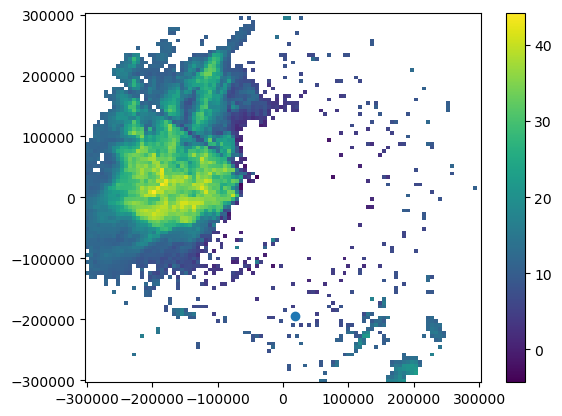

In [8]:
x = test_grid_radar.x['data']
y = test_grid_radar.y['data']
reflectivity = test_grid_radar.fields['reflectivity']['data'][4]
plot = plt.pcolormesh(x,y,reflectivity)
plt.scatter(18000,-195000)
plt.colorbar(plot)

In [9]:
radius_interval = 100
radius_min = 0
radius_max = 200000
center_inds = [-195000,23000]
NOP = 1000
cylindrical_data, THETA, rad_arr = x_y_grid_to_cylindrical(center_inds,radius_min,radius_max,radius_interval, NOP,x,y,reflectivity)



ValueError: One of the requested xi is out of bounds in dimension 0

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
s = ax.pcolormesh(THETA, rad_arr/1000,cylindrical_data)
plt.colorbar(s)

# plt.pcolormesh(cylindrical_data)